# 2. Entendimiento y Preparación Inicial de los Datos

Tras haber definido los objetivos de negocio y los KPIs de éxito, entramos en la fase técnica de **Data Understanding**. El propósito de este notebook no es solo visualizar los datos, sino transformar la materia prima "cruda" en un dataset estructurado, limpio y listo para el análisis profundo, garantizando desde el inicio la integridad metodológica del proyecto.

Para lograr esto de manera ordenada y evitar sesgos, seguiremos una estructura secuencial estricta:

1.  **Auditoría Técnica (Health Check):** Realizaremos un diagnóstico inicial para identificar la "salud" del dataset: detección de valores nulos, inconsistencias en tipos de datos (ej. variables numéricas codificadas como texto) y cardinalidad.
2.  **Saneamiento Estructural:** Antes de cualquier análisis, corregiremos los formatos de las variables para hacerlas legibles por el sistema.
3.  **Estrategia de Particionamiento (Data Splitting):** Una vez limpia la estructura, dividiremos los datos en conjuntos de **Entrenamiento** y **Prueba (Hold-out)**. Este paso se realiza **antes** del análisis exploratorio profundo para evitar la "Fuga de Información Humana" (*Human Bias Leakage*), asegurando que nuestras conclusiones visuales no estén contaminadas por los datos que usaremos para evaluar el modelo.
4.  **Análisis Exploratorio Profundo (Deep EDA):** Finalmente, utilizaremos exclusivamente el set de **Entrenamiento** para buscar patrones, correlaciones y *drivers* de riesgo que expliquen el comportamiento de la siniestralidad (`claim_status`).

> **Nota Metodológica:** En esta fase nos enfocamos en la limpieza **estructural** (formatos y duplicados). La limpieza **estadística** (como imputación de nulos o escalado de variables) se realizará posteriormente en la fase de *Data Preparation*, respetando estrictamente los límites del set de entrenamiento.

In [45]:
# importaciones
import math
import re
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split

In [43]:
# visuals
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
warnings.filterwarnings("ignore")

In [3]:
# Routes
DATA_PATH = Path("../data")
RAW_DATA_FILE = DATA_PATH / "raw" / "claims_dataset.csv"
PROCESSED_DATA_PATH = DATA_PATH / "processed"
# Seed for reproducibility
SEED = 42

In [4]:
# Load dataset
try:
    df = pd.read_csv(RAW_DATA_FILE, sep=";")
    print(f"Dataset loaded successfully. Dimensions: {df.shape}")
except FileNotFoundError:
    print("Error! The file does not exist. Check the path.")

# Initial overview
df.head()

Dataset loaded successfully. Dimensions: (58592, 41)


,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [5]:
# Data Health Check Function
def data_health_check(df):
    print(f"1. Dimensiones del Dataset: {df.shape}")
    print("\n2. Duplicados:")
    print(f"   Filas duplicadas: {df.duplicated().sum()}")

    print("\n3. Tipos de Datos y Valores Nulos:")
    info_df = pd.DataFrame(df.dtypes, columns=["Dtype"])
    info_df["Nunique"] = df.nunique()
    info_df["Missing_Values"] = df.isnull().sum()
    info_df["%_Missing"] = (df.isnull().sum() / len(df)) * 100
    display(info_df.sort_values(by="%_Missing", ascending=False))


data_health_check(df)

1. Dimensiones del Dataset: (58592, 41)

2. Duplicados:
   Filas duplicadas: 0

3. Tipos de Datos y Valores Nulos:


,Dtype,Nunique,Missing_Values,%_Missing
policy_id,str,58592,0,0.0
subscription_length,float64,140,0,0.0
vehicle_age,float64,49,0,0.0
customer_age,int64,41,0,0.0
region_code,str,22,0,0.0
region_density,int64,22,0,0.0
segment,str,6,0,0.0
model,str,11,0,0.0
fuel_type,str,3,0,0.0
max_torque,str,9,0,0.0


In [12]:
# Creating a clean copy of the dataframe for further processing
df_clean = df.copy()

## 2.1 Limpieza y Preprocesamiento Inicial

Antes de iniciar el análisis exploratorio, se ejecutará una fase de limpieza de datos orientada a estructurar la información para el modelado. Las acciones específicas de limpieza incluyen:

* **Eliminación de Identificadores (`policy_id`):** Se descartará esta variable dado que posee una cardinalidad total (un valor único por registro), por lo que carece de valor predictivo. Su eliminación facilita además la detección real de registros duplicados basados en características del vehículo o cliente.
* **Estandarización Binaria:** Conversión de todas las variables categóricas dicotómicas (ej. "Yes"/"No", "True"/"False") a formato numérico entero (`1` / `0`). Esto habilita el cálculo directo de correlaciones y métricas de riesgo.
* **Extracción de Atributos de Motor:** Descomposición de las variables complejas `max_torque` y `max_power` (actualmente texto). Se extraerán dos nuevas características numéricas por variable: *Magnitud* (Fuerza/Potencia) y *Régimen* (RPM), permitiendo evaluar el impacto aislado de la potencia del vehículo en la siniestralidad.
* **Validación de Redundancia:** Se realizará un test de unicidad entre `region_code` y `region_density`, asi como de `model` y `engine_type`. Si se confirma una relación 1 a 1 (donde el código no aporta información adicional a la densidad), se eliminará `region_code` y `engine_type` para evitar multicolinealidad. De lo contrario, se conservará para capturar riesgos variables latentes.
* **Saneamiento de Cadenas de Texto:** Aplicación de *trimming* (eliminación de espacios en blanco al inicio y final) en todas las variables categóricas para evitar la duplicación de categorías por errores de formato.
* **Deduplicación de Registros:** Tras la limpieza estructural (que puede generar filas idénticas al remover el ID), se procederá a eliminar los duplicados exactos. Esta acción es crítica para mitigar el riesgo de sobreajuste (*overfitting*) por memorización y prevenir la fuga de información (*data leakage*) entre los conjuntos de entrenamiento y prueba.

In [13]:
# Dropping an unnecessary column (if exists)
if "policy_id" in df_clean.columns:
    df_clean = df_clean.drop("policy_id", axis=1)
df_clean.head()

,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,max_power,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,97.89bhp@3600rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,88.77bhp@4000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [14]:
# Converting binary categorical variables to 0/1
binary_cols = [col for col in df_clean.columns if col.startswith("is_")]

for col in binary_cols:
    unique_vals = df_clean[col].unique()
    df_clean[col] = df_clean[col].map(
        {"Yes": 1, "No": 0, "True": 1, "False": 0, "1": 1, "0": 0}
    )
    df_clean[col] = df_clean[col].astype(int)

print(f"-> {len(binary_cols)} binary columns converted to 0/1.")
df_clean.head()

-> 17 binary columns converted to 0/1.


,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,max_power,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,...,1,1,1,1,1,0,1,1,3,0
1,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,97.89bhp@3600rpm,...,0,1,1,1,1,1,1,1,4,0
2,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,...,1,1,1,1,1,0,1,1,3,0
3,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,1,0,0,0,1,0,0
4,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,88.77bhp@4000rpm,...,0,1,1,1,0,0,1,1,5,0


In [15]:
# Function to split engine specs into numeric columns
def split_engine_specs(val):
    if pd.isna(val):
        return 0, 0
    matches = re.findall(r"(\d+\.?\d*)", str(val))

    if len(matches) >= 2:
        return float(matches[0]), float(matches[1])
    elif len(matches) == 1:
        return float(matches[0]), 0
    else:
        return 0, 0


# apply to max_torque
df_clean[["torque_nm", "torque_rpm"]] = df_clean["max_torque"].apply(
    lambda x: pd.Series(split_engine_specs(x))
)

# drop max_torque after extraction
if "max_torque" in df_clean.columns:
    df_clean = df_clean.drop("max_torque", axis=1)

# apply to max_power
df_clean[["power_bhp", "power_rpm"]] = df_clean["max_power"].apply(
    lambda x: pd.Series(split_engine_specs(x))
)

# drop max_power after extraction
if "max_power" in df_clean.columns:
    df_clean = df_clean.drop("max_power", axis=1)

print("Created new numeric columns: torque_nm, torque_rpm, power_bhp, power_rpm")
df_clean[["torque_nm", "torque_rpm", "power_bhp", "power_rpm"]].head()

Created new numeric columns: torque_nm, torque_rpm, power_bhp, power_rpm


,torque_nm,torque_rpm,power_bhp,power_rpm
0,250.0,2750.0,113.45,4000.0
1,200.0,1750.0,97.89,3600.0
2,250.0,2750.0,113.45,4000.0
3,60.0,3500.0,40.36,6000.0
4,200.0,3000.0,88.77,4000.0


In [16]:
# check redundancy between region_code and region_density
redundancy_check = df_clean.groupby("region_code")["region_density"].nunique()
if (
    redundancy_check.max() == 1
    and df_clean["region_code"].nunique() == df_clean["region_density"].nunique()
):
    print("Region_code and Region_Density are 100% redundant.")
    print("-> each region_code maps to a single region_density value.")

    df_clean = df_clean.drop("region_code", axis=1)
else:
    print("region_code and region_density are not fully redundant.")
    print(f"-> Maximum densities per code: {redundancy_check.max()}")

df_clean.head()

Region_code and Region_Density are 100% redundant.
-> each region_code maps to a single region_density value.


,subscription_length,vehicle_age,customer_age,region_density,segment,model,fuel_type,engine_type,airbags,is_esc,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,torque_nm,torque_rpm,power_bhp,power_rpm
0,9.3,1.2,41,8794,C2,M4,Diesel,1.5 L U2 CRDi,6,1,...,1,0,1,1,3,0,250.0,2750.0,113.45,4000.0
1,8.2,1.8,35,27003,C1,M9,Diesel,i-DTEC,2,0,...,1,1,1,1,4,0,200.0,1750.0,97.89,3600.0
2,9.5,0.2,44,8794,C2,M4,Diesel,1.5 L U2 CRDi,6,1,...,1,0,1,1,3,0,250.0,2750.0,113.45,4000.0
3,5.2,0.4,44,73430,A,M1,CNG,F8D Petrol Engine,2,0,...,0,0,0,1,0,0,60.0,3500.0,40.36,6000.0
4,10.1,1.0,56,5410,B2,M5,Diesel,1.5 Turbocharged Revotorq,2,0,...,0,0,1,1,5,0,200.0,3000.0,88.77,4000.0


In [17]:
# check redundancy between model and engine_type
redundancy_check = df_clean.groupby("model")["engine_type"].nunique()
if (
    redundancy_check.max() == 1
    and df_clean["model"].nunique() == df_clean["engine_type"].nunique()
):
    print("Model and Engine_Type are 100% redundant.")
    print("-> each model maps to a single engine_type value.")

    df_clean = df_clean.drop("engine_type", axis=1)
else:
    print("model and engine_type are not fully redundant.")
    print(f"-> Maximum densities per code: {redundancy_check.max()}")

df_clean.head()

Model and Engine_Type are 100% redundant.
-> each model maps to a single engine_type value.


,subscription_length,vehicle_age,customer_age,region_density,segment,model,fuel_type,airbags,is_esc,is_adjustable_steering,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,torque_nm,torque_rpm,power_bhp,power_rpm
0,9.3,1.2,41,8794,C2,M4,Diesel,6,1,1,...,1,0,1,1,3,0,250.0,2750.0,113.45,4000.0
1,8.2,1.8,35,27003,C1,M9,Diesel,2,0,1,...,1,1,1,1,4,0,200.0,1750.0,97.89,3600.0
2,9.5,0.2,44,8794,C2,M4,Diesel,6,1,1,...,1,0,1,1,3,0,250.0,2750.0,113.45,4000.0
3,5.2,0.4,44,73430,A,M1,CNG,2,0,0,...,0,0,0,1,0,0,60.0,3500.0,40.36,6000.0
4,10.1,1.0,56,5410,B2,M5,Diesel,2,0,1,...,0,0,1,1,5,0,200.0,3000.0,88.77,4000.0


In [18]:
# Cleaning categorical columns by stripping whitespace
cat_cols = df_clean.select_dtypes(include=["str"]).columns

for col in cat_cols:
    df_clean[col] = df_clean[col].str.strip()
    print(f"-> {col} cleaned.")
df_clean.head()

-> segment cleaned.
-> model cleaned.
-> fuel_type cleaned.
-> rear_brakes_type cleaned.
-> transmission_type cleaned.
-> steering_type cleaned.


,subscription_length,vehicle_age,customer_age,region_density,segment,model,fuel_type,airbags,is_esc,is_adjustable_steering,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,torque_nm,torque_rpm,power_bhp,power_rpm
0,9.3,1.2,41,8794,C2,M4,Diesel,6,1,1,...,1,0,1,1,3,0,250.0,2750.0,113.45,4000.0
1,8.2,1.8,35,27003,C1,M9,Diesel,2,0,1,...,1,1,1,1,4,0,200.0,1750.0,97.89,3600.0
2,9.5,0.2,44,8794,C2,M4,Diesel,6,1,1,...,1,0,1,1,3,0,250.0,2750.0,113.45,4000.0
3,5.2,0.4,44,73430,A,M1,CNG,2,0,0,...,0,0,0,1,0,0,60.0,3500.0,40.36,6000.0
4,10.1,1.0,56,5410,B2,M5,Diesel,2,0,1,...,0,0,1,1,5,0,200.0,3000.0,88.77,4000.0


In [19]:
data_health_check(df_clean)

1. Dimensiones del Dataset: (58592, 40)

2. Duplicados:
   Filas duplicadas: 1894

3. Tipos de Datos y Valores Nulos:


,Dtype,Nunique,Missing_Values,%_Missing
subscription_length,float64,140,0,0.0
vehicle_age,float64,49,0,0.0
customer_age,int64,41,0,0.0
region_density,int64,22,0,0.0
segment,str,6,0,0.0
model,str,11,0,0.0
fuel_type,str,3,0,0.0
airbags,int64,3,0,0.0
is_esc,int64,2,0,0.0
is_adjustable_steering,int64,2,0,0.0


In [20]:
# 1. Verify exact duplicates (Everything same, incl. target)
duplicados_exactos = df_clean.duplicated().sum()

# 2. Verify conflicting duplicates (Same features, different target)
cols_features = [c for c in df_clean.columns if c != "claim_status"]
conflictos = df_clean.groupby(cols_features)["claim_status"].nunique()
# If nunique > 1, it means that for those features there are 0 and 1 at the same time
n_conflictos = conflictos[conflictos > 1].shape[0]

print("Duplicate Analysis:")
print(f"-> Totally identical records: {duplicados_exactos}")
print(f"-> Identical profiles with different outcomes (Conflicts): {n_conflictos}")

# 3. ACTION: REMOVE DUPLICATES
# Keep the first occurrence and delete the rest
df_clean = df_clean.drop_duplicates(keep="first")

print("\nDuplicates have been removed.")
print(f"Final dimensions of the dataset: {df_clean.shape}")

Duplicate Analysis:
-> Totally identical records: 1894
-> Identical profiles with different outcomes (Conflicts): 262

Duplicates have been removed.
Final dimensions of the dataset: (56698, 40)


## 2.2 Estrategia de Particionamiento (Data Splitting)

Una vez garantizada la integridad estructural de los datos, procederemos a la división estratégica del dataset. Este paso se realiza **antes** del análisis exploratorio profundo (Deep EDA) para cumplir con el principio de **"Ceguera del Evaluador"** y evitar la fuga de información (*Data Leakage*).

La estrategia consiste en:

1.  **Segregación del Test Set (Hold-out):** Se separará un **20%** de los datos como conjunto de prueba final. Este subconjunto permanecerá aislado y no será visualizado ni utilizado para tomar decisiones estadísticas (como imputación de nulos o tratamiento de outliers) durante la fase de exploración.
2.  **Estratificación:** Dado el desbalance de la variable objetivo (6.4% de reclamos), el particionamiento será **estratificado**. Esto garantiza que tanto el conjunto de entrenamiento como el de prueba mantengan la misma proporción de siniestralidad que la población original, asegurando una evaluación justa.
3.  **Base para EDA:** El Análisis Exploratorio de Datos subsiguiente se ejecutará exclusivamente sobre el **80% de Entrenamiento**, permitiendo descubrir patrones generalizables sin contaminar nuestra visión con los datos de prueba.

In [21]:
# 1. split features and target
X = df_clean.drop(["claim_status"], axis=1)
y = df_clean["claim_status"]

# 2. Create the Final Test Set (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# 3. Prepare the Full Training DataFrame
train_df = pd.concat([X_train_full, y_train_full], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Reset index for both sets
train_df = train_df.reset_index(drop=True)

# 4. Create Stratified K-Folds in the Training Set
# Initialize the column to -1
train_df["kfold"] = -1

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Fill the 'kfold' column
for fold, (_train_idx, val_idx) in enumerate(
    kf.split(X=train_df, y=train_df["claim_status"])
):
    train_df.loc[val_idx, "kfold"] = fold

# 5. Summary of the splits
print("General Dimensions:")
print(f"-> Train Set (for CV): {train_df.shape[0]} rows (80%)")
print(f"-> Test Set (Hold-out): {test_df.shape[0]} rows (20%)")

print("\nDistribution of Folds in Train Set:")
print(train_df.kfold.value_counts())

# 6. Save the files
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)

# Save the train set with the folds column and the clean test set
train_df.to_csv(PROCESSED_DATA_PATH / "train_folds.csv", index=False)
test_df.to_csv(PROCESSED_DATA_PATH / "test.csv", index=False)

General Dimensions:
-> Train Set (for CV): 45358 rows (80%)
-> Test Set (Hold-out): 11340 rows (20%)

Distribution of Folds in Train Set:
kfold
2    9072
1    9072
0    9072
3    9071
4    9071
Name: count, dtype: int64


## 2.3 Análisis Exploratorio de Datos (Deep EDA)

Con la integridad estructural asegurada y el conjunto de prueba aislado, iniciamos el análisis profundo sobre el set de entrenamiento. El objetivo central de esta fase es **pasar de los datos al conocimiento**, identificando qué características del vehículo o del cliente están correlacionadas con una mayor probabilidad de siniestro.

Nuestra ruta de análisis responderá a cinco preguntas clave de negocio:

1.  **Análisis de la Variable Objetivo (Baseline):**
    * *Pregunta:* ¿Cuál es la tasa base de reclamos? (Cualquier segmento que supere esta tasa será considerado de "Alto Riesgo").
    * *Técnica:* Gráfico de Frecuencia y cálculo de ratio de desbalance.

2.  **Variables Numéricas y de Motor:**
    * *Pregunta:* ¿Influye la potencia (`power_bhp`), el par motor (`torque_nm`) o la antigüedad del vehículo en la decisión de reclamar?
    * *Técnica:* Histogramas (distribución) y Boxplots (capacidad de discriminación).

3.  **Variables Binarias (Banderas):**
    * *Pregunta:* Dado que gran parte del dataset son características de seguridad (`is_esc`, `is_parking_sensors`), ¿su presencia realmente reduce el riesgo? ¿Existen variables irrelevantes (varianza nula)?
    * *Técnica:* Análisis de Varianza y Gráfico de Impacto de Riesgo (Dumbbell Plot).

4.  **Variables Categóricas:**
    * *Pregunta:* ¿Existen marcas, segmentos o tipos de combustible inherentemente más riesgosos?
    * *Técnica:* Gráficos de barras de "Tasa de Siniestralidad por Categoría" vs "Promedio Global".

5.  **Correlaciones Multivariadas:**
    * *Pregunta:* ¿Hay variables redundantes o fuertemente correlacionadas entre sí?
    * *Técnica:* Mapa de Calor (Heatmap) con correlación de Spearman.

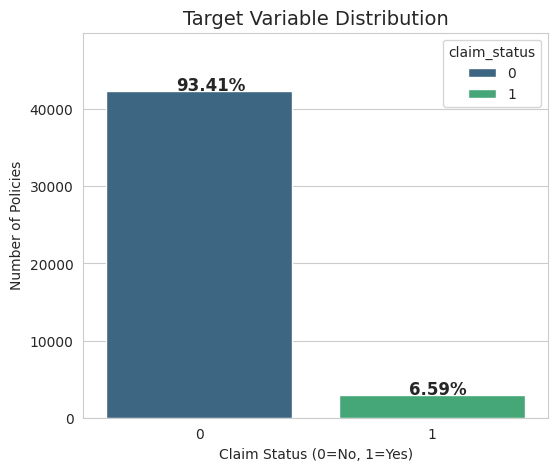

--- Target Statistics ---
Total No Claims (0): 42,371
Total Claims (1):    2,987
Base Claim Rate: 6.59%
Imbalance Factor: 1:14.2


In [27]:
def analyze_target_distribution(df, target="claim_status"):
    """
    Visualizes and computes statistics for the target variable distribution.
    """
    plt.figure(figsize=(6, 5))

    # Count plot
    ax = sns.countplot(x=target, data=df, palette="viridis", hue=target)

    # Percentage annotations
    total = len(df)
    for p in ax.patches:
        percentage = f"{100 * p.get_height() / total:.2f}%"
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 100
        ax.annotate(
            percentage, (x, y), size=12, weight="bold"
        ) if percentage != "0.00%" else None

    plt.title("Target Variable Distribution", fontsize=14)
    plt.xlabel("Claim Status (0=No, 1=Yes)")
    plt.ylabel("Number of Policies")
    plt.ylim(0, total * 1.1)
    plt.show()

    # Exact numerical calculation
    counts = df[target].value_counts()
    ratio = df[target].value_counts(normalize=True)[1] * 100

    print("--- Target Statistics ---")
    print(f"Total No Claims (0): {counts[0]:,}")
    print(f"Total Claims (1):    {counts[1]:,}")
    print(f"Base Claim Rate: {ratio:.2f}%")
    print(f"Imbalance Factor: 1:{round(counts[0] / counts[1], 1)}")


analyze_target_distribution(train_df)

Analyzing 16 numerical variables...



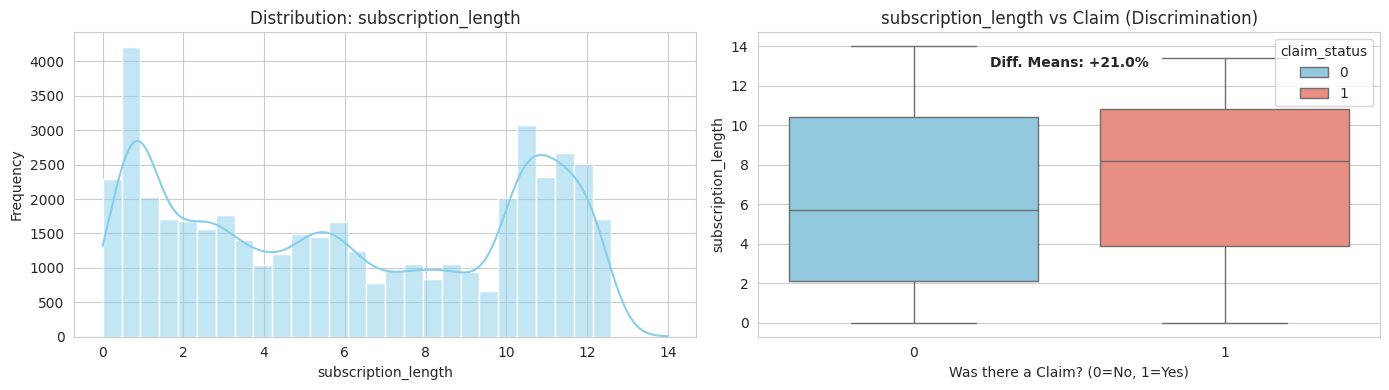

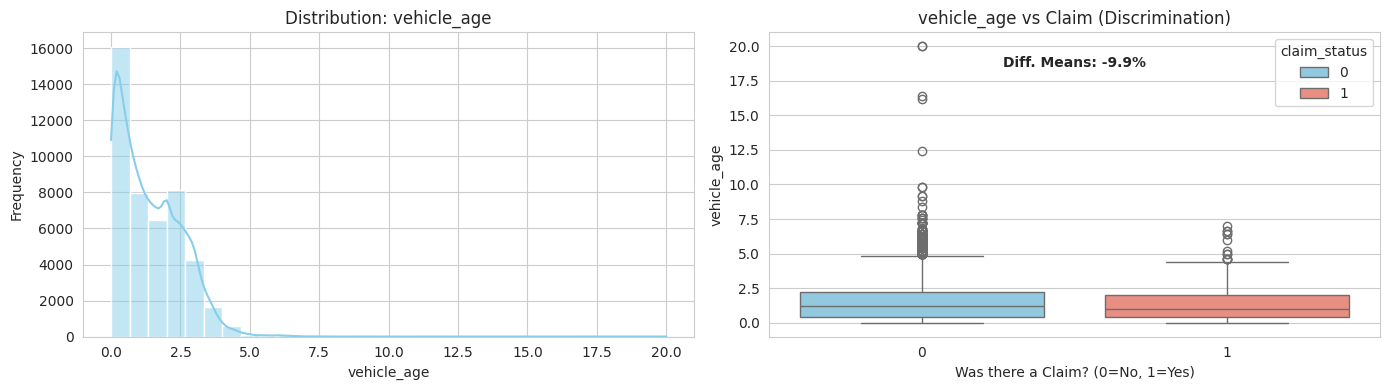

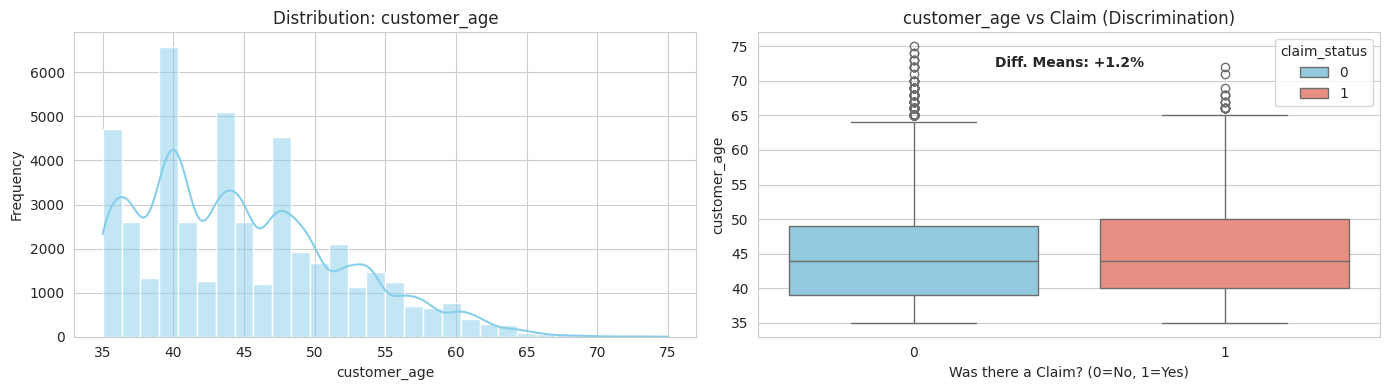

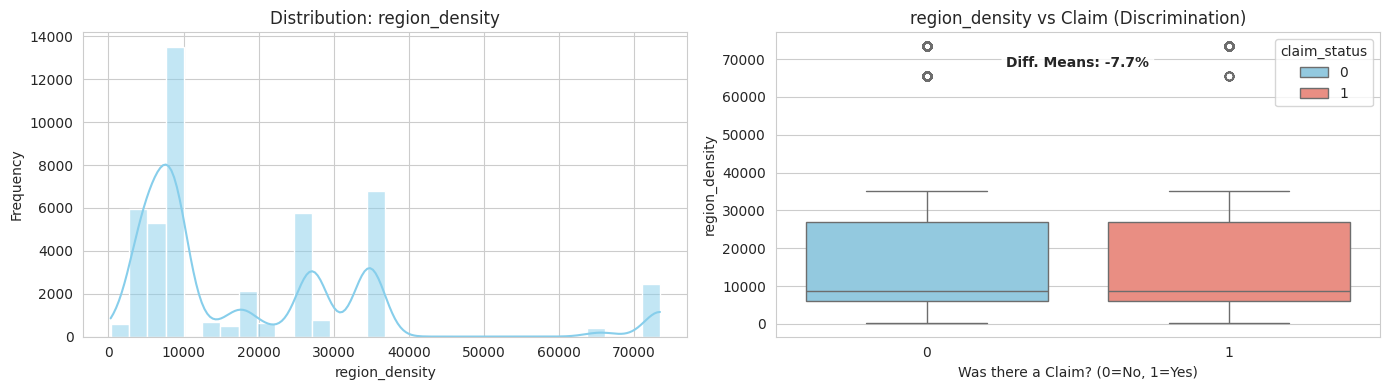

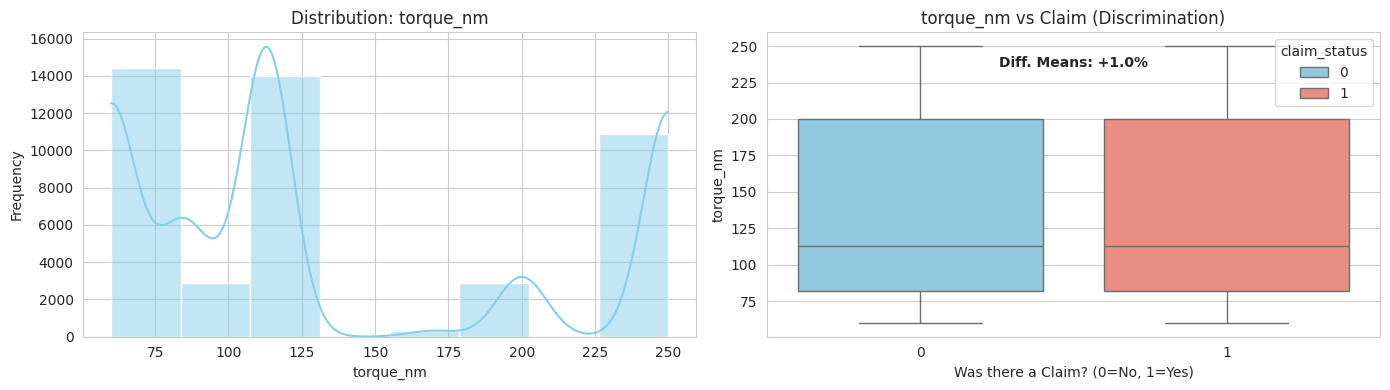

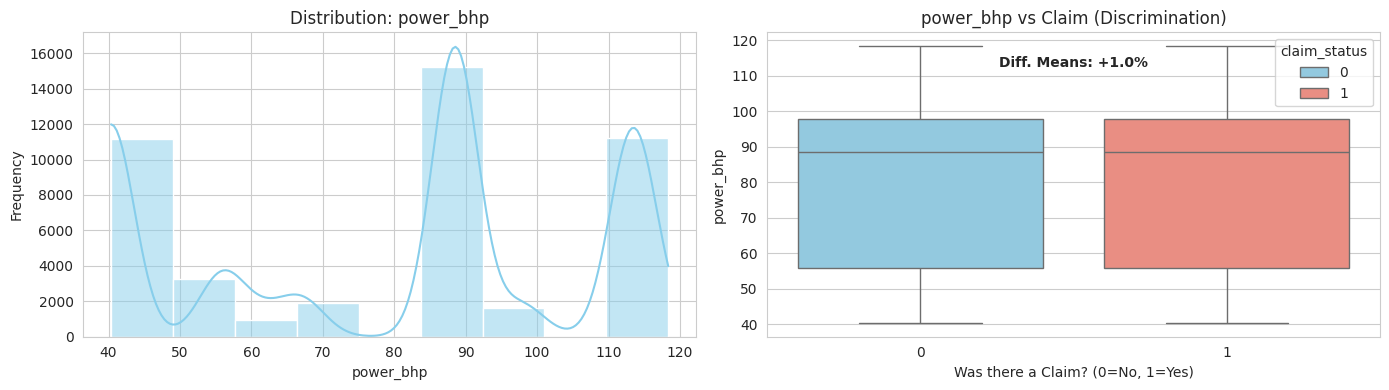

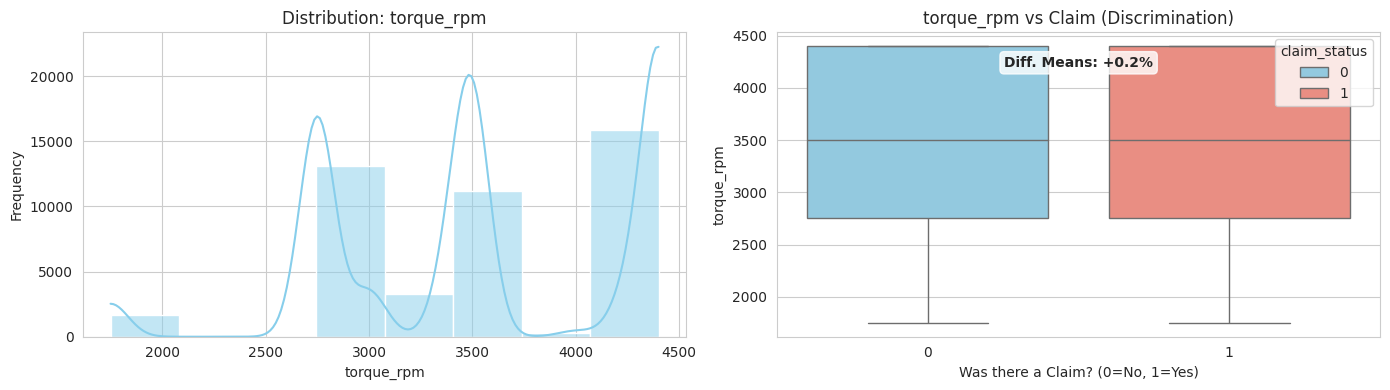

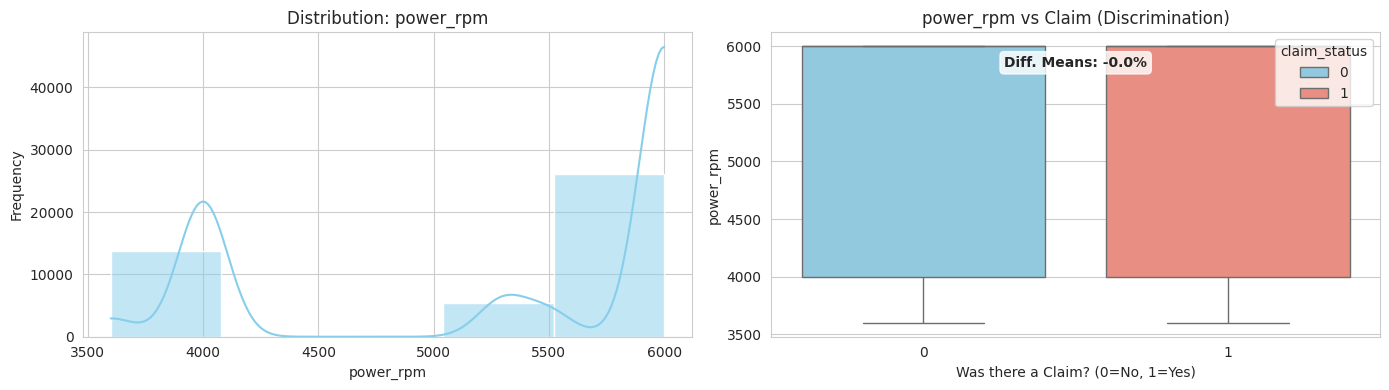

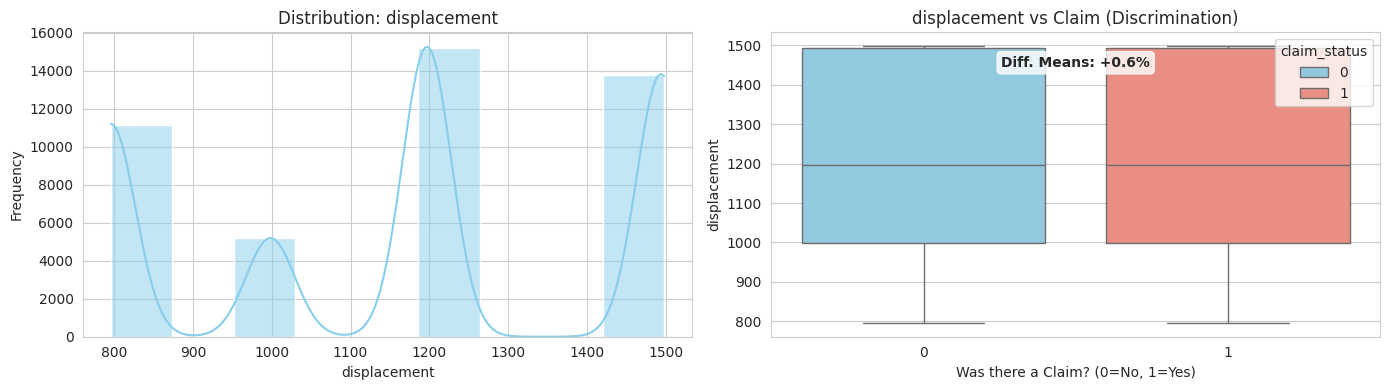

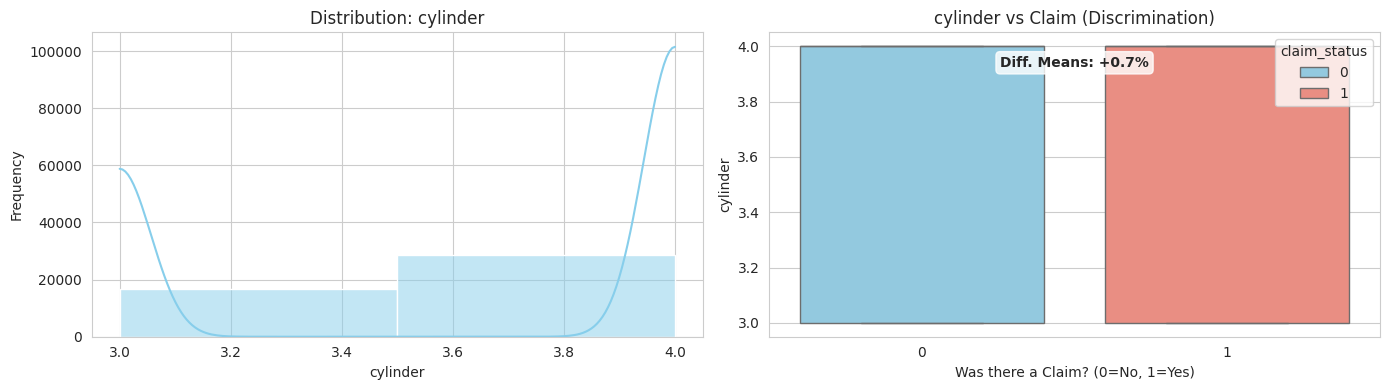

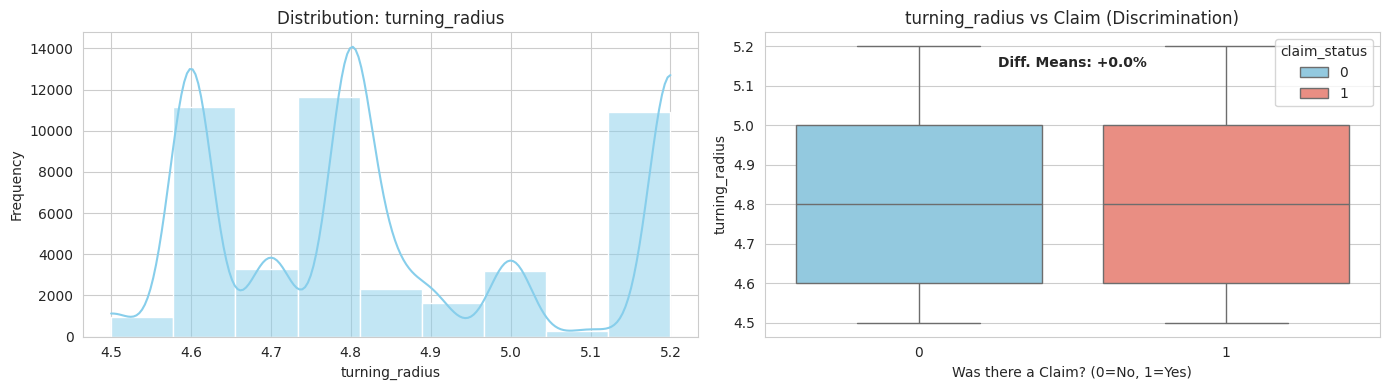

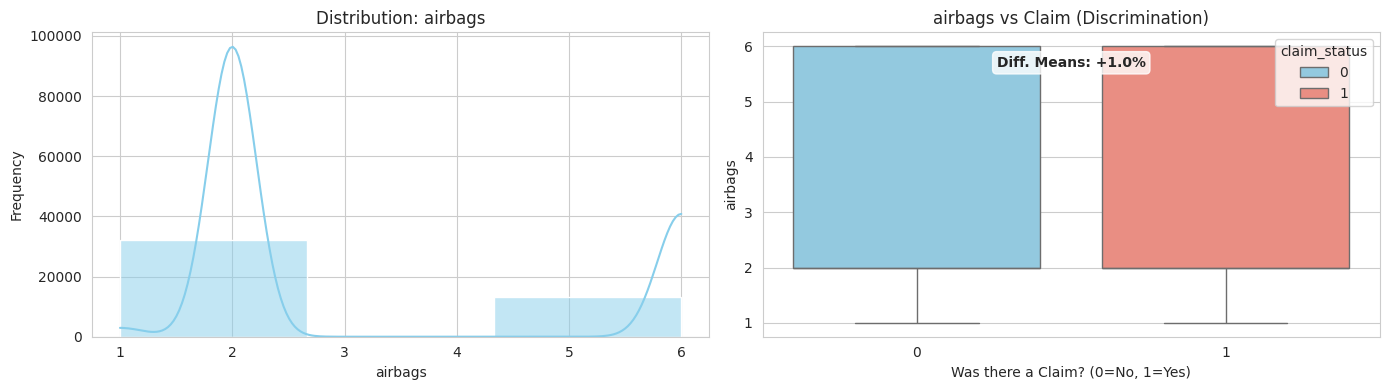

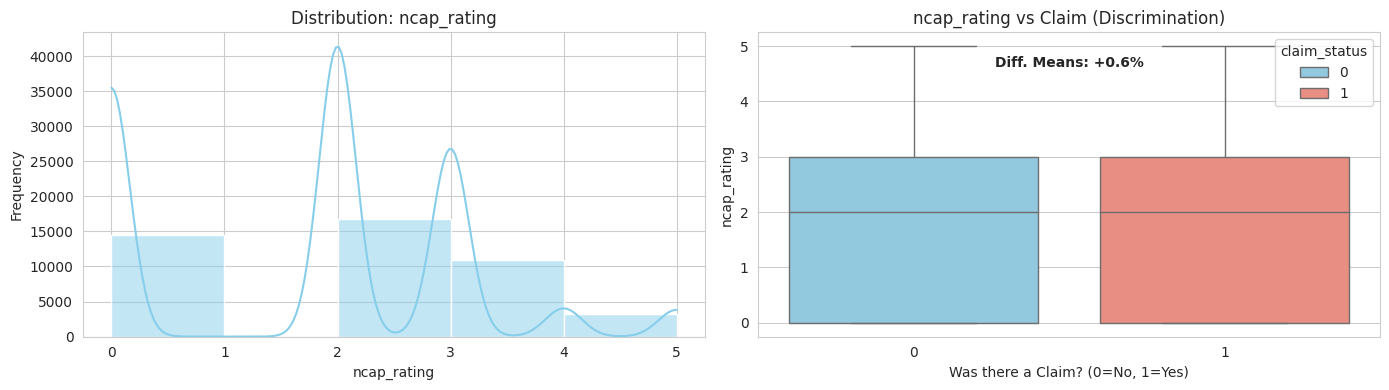

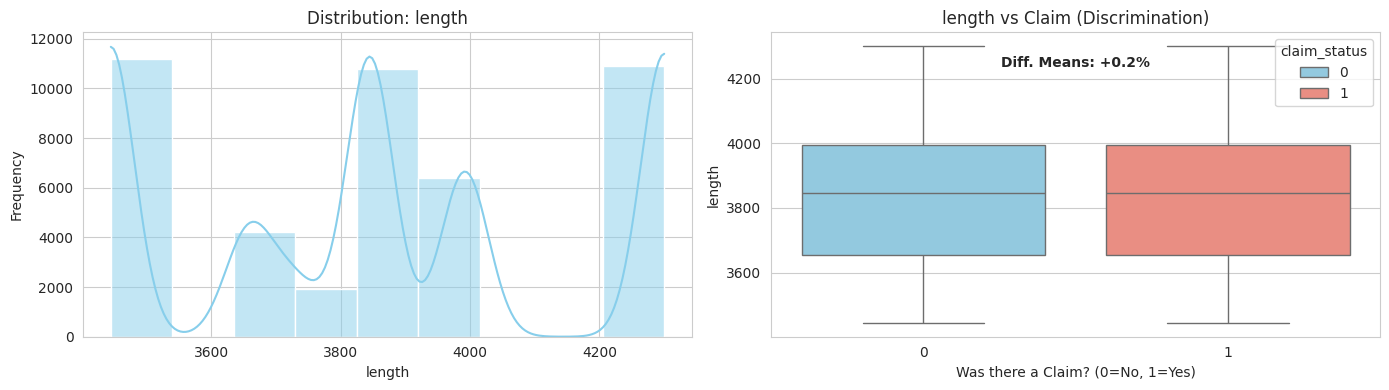

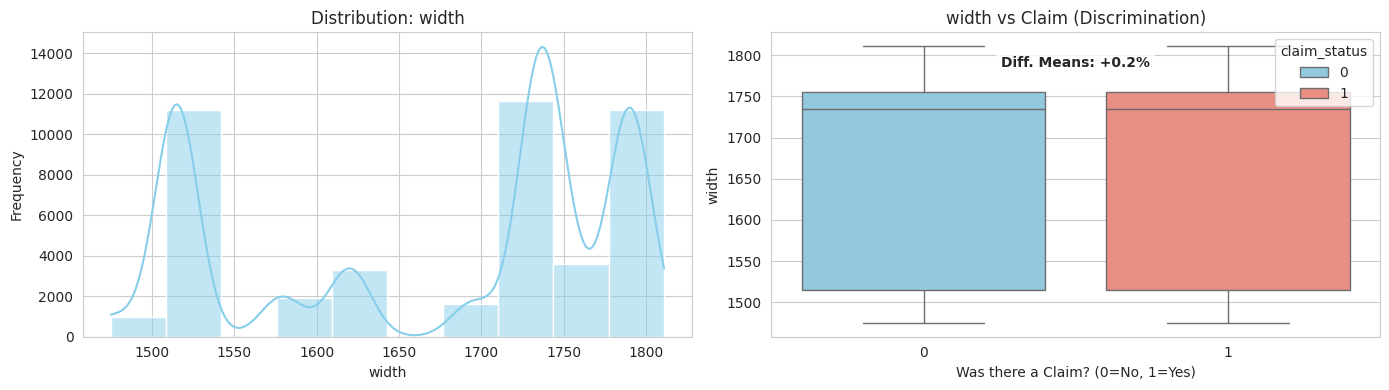

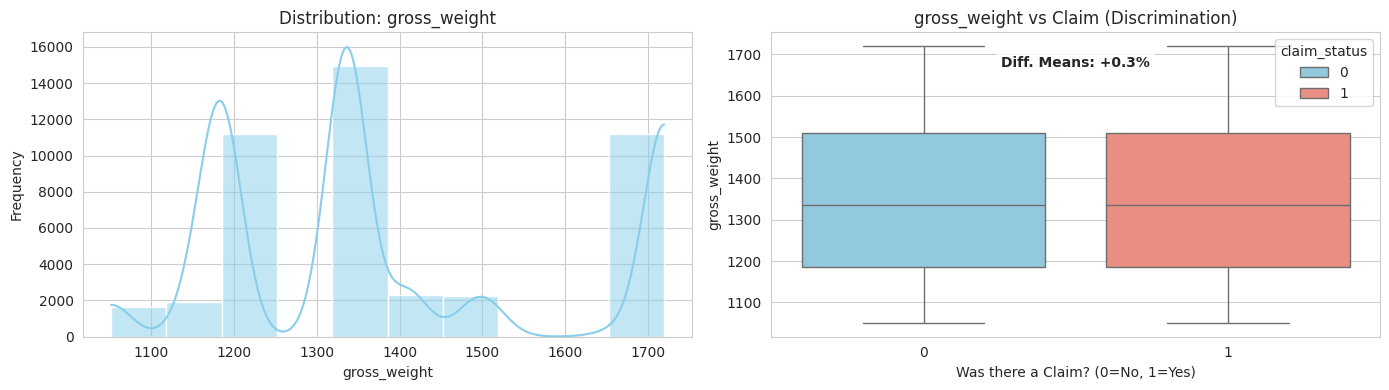

In [35]:
def analyze_expanded_numerical_drivers(df, target="claim_status"):
    num_cols = [
        # 1. Client and Policy Profile
        "subscription_length",
        "vehicle_age",
        "customer_age",
        "region_density",
        # 2. Engine and Performance (Feature Engineering)
        "torque_nm",
        "power_bhp",
        "torque_rpm",
        "power_rpm",
        "displacement",
        "cylinder",
        "turning_radius",
        # 3. Safety and Physical Dimensions
        "airbags",
        "ncap_rating",
        "length",
        "width",
        "gross_weight",
    ]

    # Filter only existing columns
    valid_cols = [c for c in num_cols if c in df.columns]

    print(f"Analyzing {len(valid_cols)} numerical variables...\n")

    for col in valid_cols:
        # Create a new figure for each variable (avoids squished plots)
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        # A. Histogram (Distribution)
        # We use bins=30 for continuous, but fewer for discrete like cylinders/airbags
        bins_val = 30 if df[col].nunique() > 10 else df[col].nunique()
        sns.histplot(
            data=df, x=col, kde=True, ax=axes[0], color="skyblue", bins=bins_val
        )
        axes[0].set_title(f"Distribution: {col}")
        axes[0].set_ylabel("Frequency")

        # B. Boxplot (Discrimination)
        sns.boxplot(
            data=df,
            x=target,
            y=col,
            ax=axes[1],
            hue=target,
            palette={"skyblue", "salmon"},
        )
        sns.move_legend(axes[1], "upper right")
        axes[1].set_title(f"{col} vs Claim (Discrimination)")
        axes[1].set_xlabel("Was there a Claim? (0=No, 1=Yes)")

        # Calculate the difference in means (Percentage Impact)
        mean_0 = df[df[target] == 0][col].mean()
        mean_1 = df[df[target] == 1][col].mean()

        # Avoid division by zero
        if mean_0 != 0:
            diff_pct = ((mean_1 - mean_0) / mean_0) * 100
            texto_diff = f"Diff. Means: {diff_pct:+.1f}%"
        else:
            texto_diff = f"Diff: {mean_1 - mean_0:.2f}"

        axes[1].text(
            0.5,
            0.9,
            texto_diff,
            horizontalalignment="center",
            verticalalignment="center",
            transform=axes[1].transAxes,
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.8, boxstyle="round"),
        )

        plt.tight_layout()
        plt.show()


analyze_expanded_numerical_drivers(train_df)

### Conclusiones del Análisis de Variables Numéricas

Tras la inspección visual de distribuciones y boxplots, se derivan dos conclusiones críticas para la estrategia de modelado:

1.  **Hallazgo de Alto Valor en `subscription_length`:**
    * **Observación:** Se detectó una clara capacidad de discriminación en la antigüedad del contrato. Los clientes con **mayor antigüedad** presentan una **tasa de reclamo superior**.
    * **Hipótesis de Negocio:** Esto sugiere un posible efecto de "derecho adquirido", donde los clientes antiguos tienden a reportar siniestros menores para "hacer valer" la prima pagada durante años. Alternativamente, podría indicar unos controles de auditoría menos estrictos para clientes fidelizados. Se recomienda al negocio investigar políticas de retención y auditoría en este segmento.

2.  **Complejidad No Lineal en Variables Físicas:**
    * **Observación:** Las variables restantes muestran una discriminación débil en sus distribuciones individuales (las medianas entre "Reclamo" y "No Reclamo" son similares).
    * **Impacto en el Modelado:** La falta de separación lineal indica que modelos simples (como una Regresión Logística básica) tendrán bajo rendimiento. Por lo que, es mandatorio utilizar algoritmos basados en árboles (**Random Forest, XGBoost**) capaces de detectar fronteras de decisión complejas y no lineales. Asimismo, se debe priorizar crear relaciones (ej. `Potencia / Peso` o `Edad * Potencia`) que revelen el riesgo oculto.

Analyzing 17 binary variables...



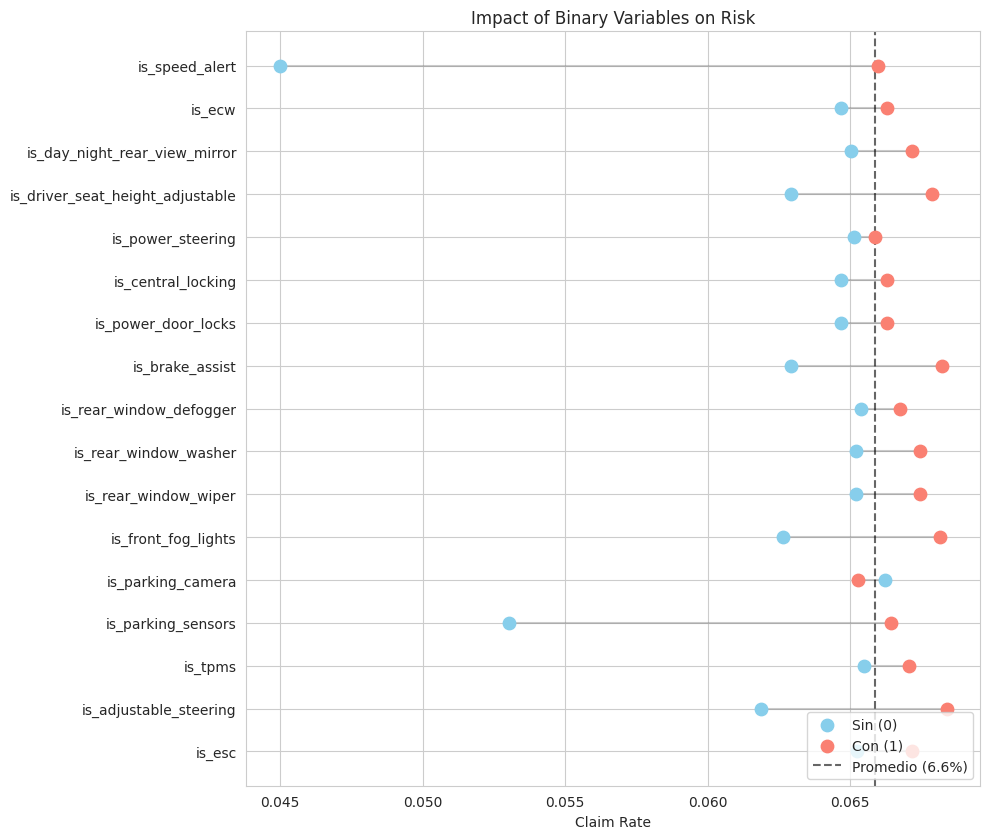

Variables with low variance (<1% or >99% presence):


,Variable,%_Presence
16,is_speed_alert,99.362847


In [ ]:
# Analysis of Binary Variables Impact
def analyze_binaries_impact(df, target="claim_status"):
    # 1. Identify binary variables (excluding target and kfold)
    binary_cols = [
        col
        for col in df.columns
        if df[col].nunique() == 2
        and col not in [target, "kfold"]
        and df[col].dtype == int
        and df[col].min() == 0
        and df[col].max() == 1
    ]

    print(f"Analyzing {len(binary_cols)} binary variables...\n")

    stats = []
    global_mean = df[target].mean()

    for col in binary_cols:
        perc_presence = df[col].mean() * 100
        df[col] = df[col].astype(int)
        rate_0 = df[df[col] == 0][target].mean()
        rate_1 = df[df[col] == 1][target].mean()

        diff = rate_1 - rate_0

        stats.append(
            {
                "Variable": col,
                "%_Presence": perc_presence,
                "Claim_Rate_if_0": rate_0,
                "Claim_Rate_if_1": rate_1,
                "Impact": diff,
                "Abs_Impact": abs(diff),
            }
        )

    stats_df = pd.DataFrame(stats).sort_values(by="Abs_Impact", ascending=False)

    plt.figure(figsize=(10, len(binary_cols) * 0.5))

    # Connecting lines
    for i, row in stats_df.iterrows():
        plt.hlines(
            y=i,
            xmin=min(row["Claim_Rate_if_0"], row["Claim_Rate_if_1"]),
            xmax=max(row["Claim_Rate_if_0"], row["Claim_Rate_if_1"]),
            color="gray",
            alpha=0.4,
        )

    # Points
    plt.scatter(
        stats_df["Claim_Rate_if_0"],
        stats_df.index,
        color="skyblue",
        label="Sin (0)",
        s=80,
        zorder=3,
    )
    plt.scatter(
        stats_df["Claim_Rate_if_1"],
        stats_df.index,
        color="salmon",
        label="Con (1)",
        s=80,
        zorder=3,
    )

    # Línea promedio global
    plt.axvline(
        x=global_mean,
        color="black",
        linestyle="--",
        label=f"Promedio ({global_mean:.1%})",
        alpha=0.6,
    )

    plt.yticks(stats_df.index, stats_df["Variable"])
    plt.xlabel("Claim Rate")
    plt.title("Impact of Binary Variables on Risk")
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    print("Variables with low variance (<1% or >99% presence):")
    display(
        stats_df[(stats_df["%_Presence"] < 1) | (stats_df["%_Presence"] > 99)][
            ["Variable", "%_Presence"]
        ]
    )


analyze_binaries_impact(train_df)

### Conclusiones del Análisis de Variables Binarias

El análisis de varianza y el gráfico de impacto (*Dumbbell Plot*) revelan patrones críticos sobre cómo el equipamiento del vehículo influye en la decisión de reclamar.

#### 1. Calidad del Dato: Detección de Variables Cuasi-Constantes
* **Hallazgo:** La variable **`is_speed_alert`** presenta una presencia del **99.36%**. Su varianza es cercana a cero, lo que anula su poder discriminatorio. Por lo que recomienda su **eliminación** en la fase de *Feature Selection* para reducir ruido.

#### 2. Patrón General:
* **Observación:** En la gran mayoría de las variables binarias (salvo una leve excepción en `is_parking_camera`), el punto de "Reclamo" (Rojo) se ubica a la derecha del punto "Sin Reclamo" (Azul). Por lo que esto indica una correlación positiva sistemática: **los vehículos más equipados tienen mayor frecuencia de reclamos**. Esto no necesariamente dice que los equipamientos sean más inseguros, pero puede ser que al tener estos equipamientos en caso de un choque, haga que sea más costoso el arreglo y por lo tanto incentiva a realizar el reclamo.

#### 3. Análisis de Drivers de Alto Impacto (Líneas Largas)
Las variables con mayor separación entre grupos (`is_parking_sensors`, `is_front_fog_lights`, `is_brake_assist`, `is_driver_seat_height_adjustable`) comparten una lógica de negocio financiera:

* **Vulnerabilidad y Costo (`is_parking_sensors`, `is_front_fog_lights`):**
    * Estas tecnologías se ubican en los parachoques, las zonas más expuestas a golpes leves. Por lo que, un golpe menor en un auto base es solo pintura. El mismo golpe en un auto equipado implica reemplazar sensores y luces, elevando el costo de reparación por encima del deducible y detonando el reclamo.
* **Proxy de Gama (`is_brake_assist`, `is_driver_seat_height_adjustable`):**
    * El ajuste de altura o asistencias avanzadas son típicos de vehículos de segmentos superiores (Gama Media/Alta). Los propietarios de vehículos de mayor valor tienden a cuidar más la estética y enfrentan costos de repuestos más altos, por lo que su umbral para activar el seguro es más bajo que el de un propietario de un vehículo de entrada.

**Conclusión para el Modelado:**
El modelo debe tratar estas variables binarias no necesariamente como factores de riesgo de *accidentalidad*, sino como fuertes predictores de **severidad del daño** y **propensión financiera al reclamo**.

Generating risk panel for 8 variables...



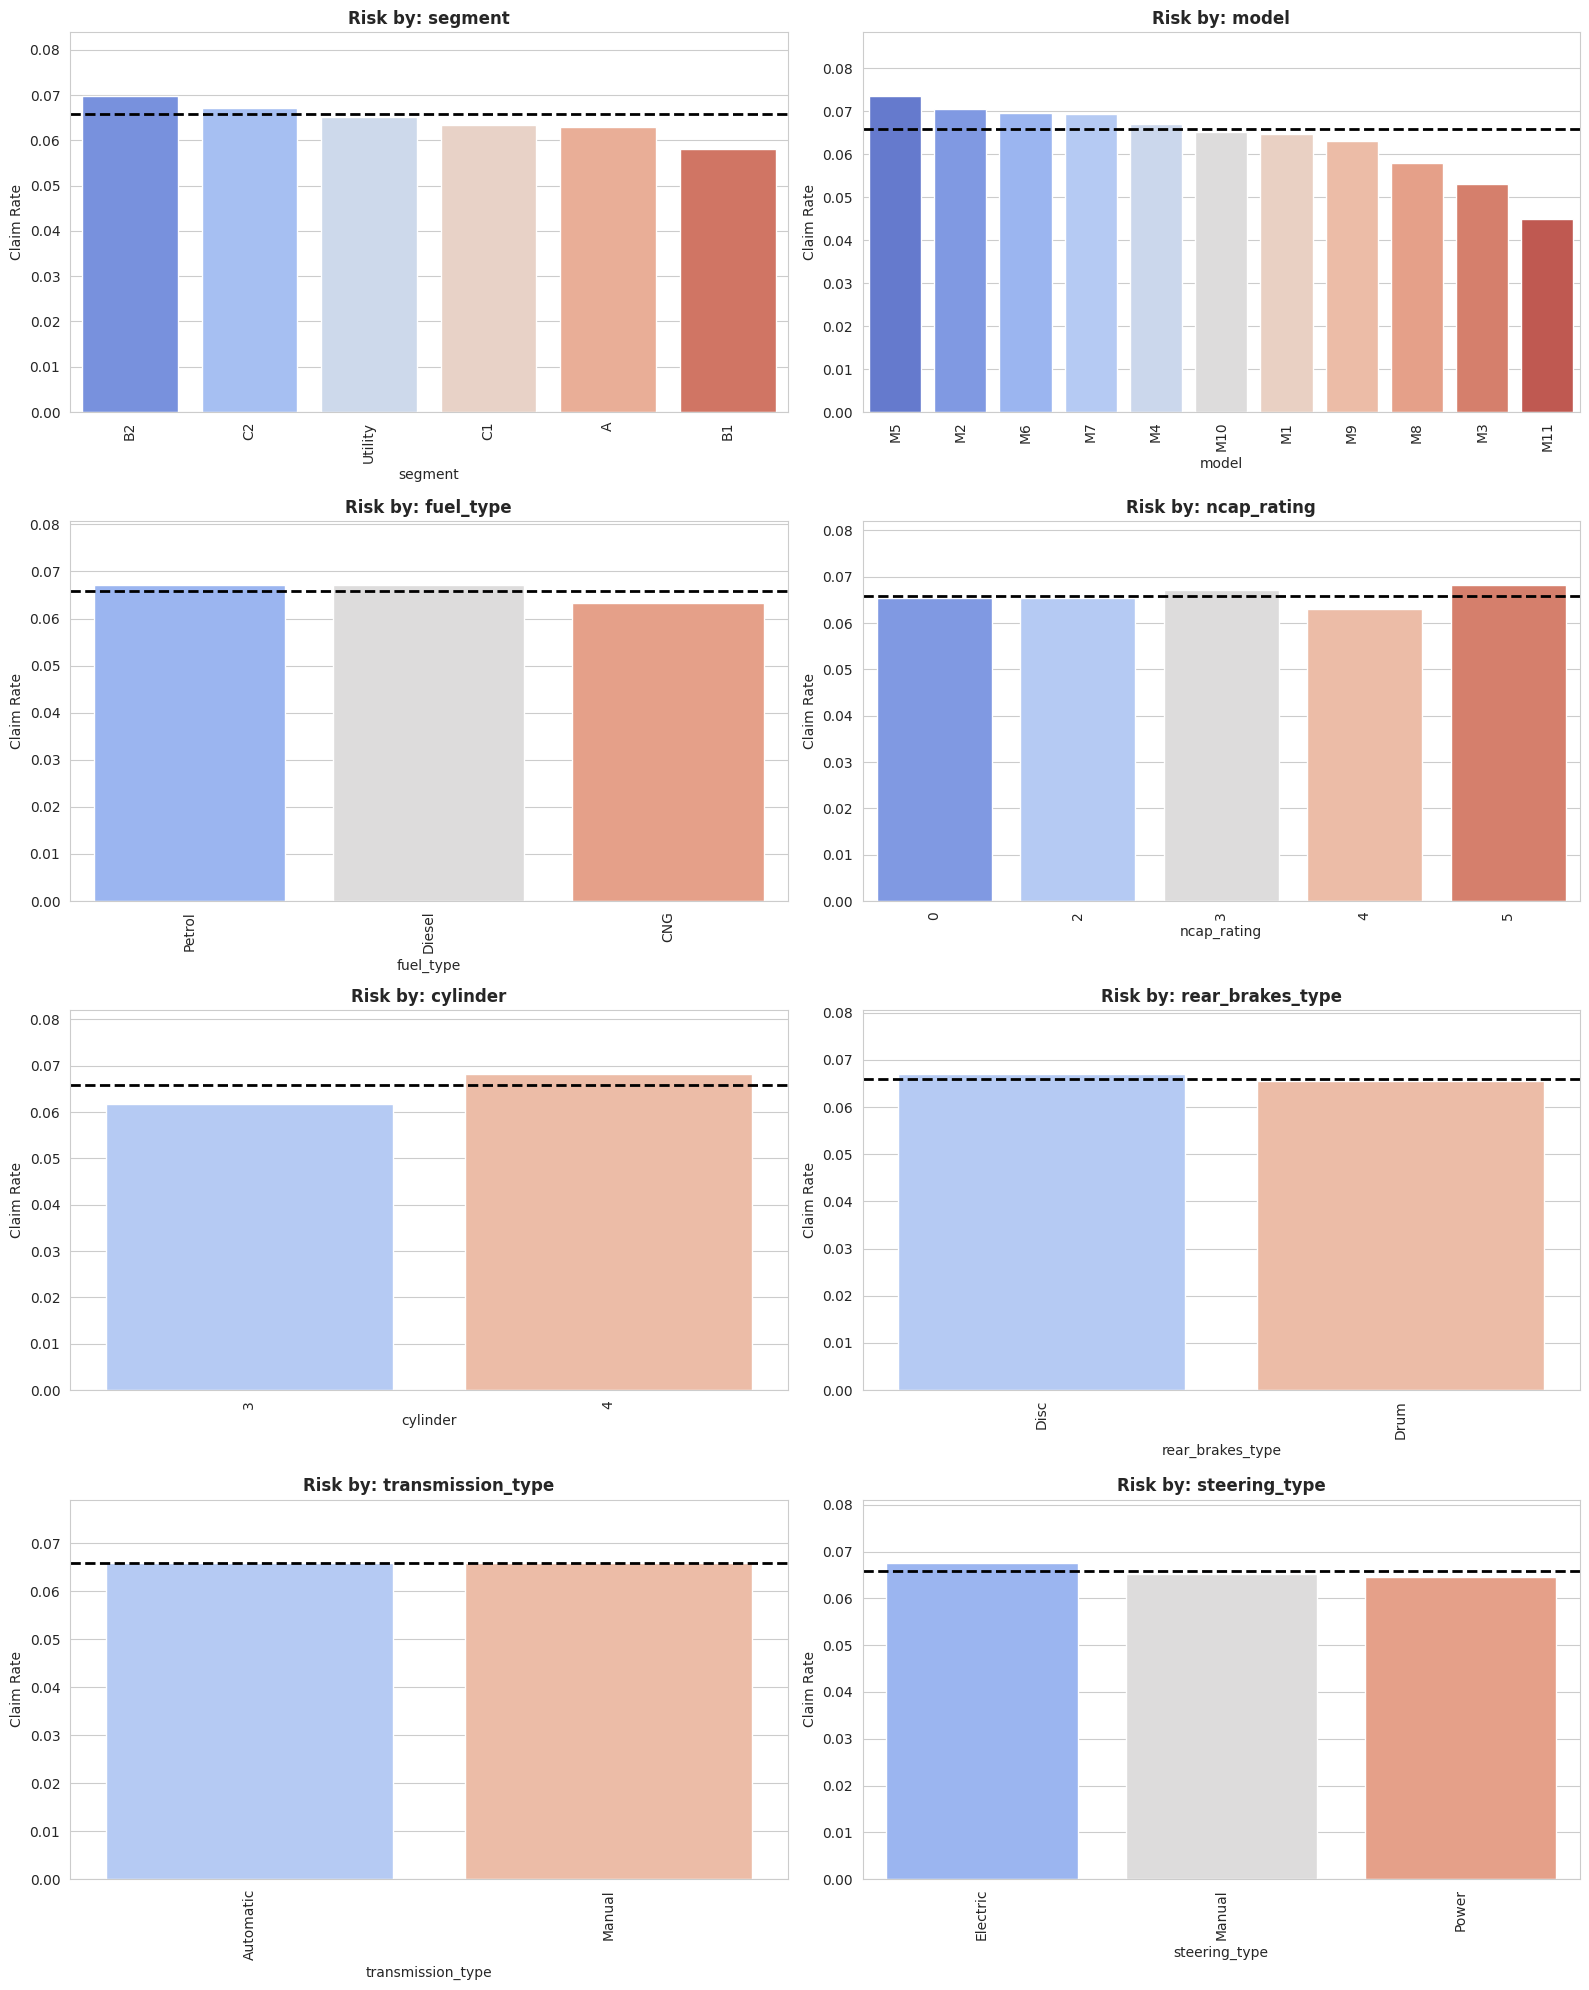

In [44]:
def analyze_categorical_risk_grid(df, target="claim_status"):
    cat_cols = [
        "segment",
        "model",
        "fuel_type",
        "ncap_rating",
        "cylinder",
        "rear_brakes_type",
        "transmission_type",
        "steering_type",
    ]

    valid_cols = [c for c in cat_cols if c in df.columns]
    n_cols = len(valid_cols)

    n_rows = math.ceil(n_cols / 2)

    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))
    axes = axes.flatten()

    global_mean = df[target].mean()

    print(f"Generating risk panel for {n_cols} variables...\n")

    for i, col in enumerate(valid_cols):
        risk_df = df.groupby(col)[target].agg(["mean", "count"]).reset_index()
        risk_df.columns = [col, "risk_rate", "volume"]
        risk_df = risk_df.sort_values(by="risk_rate", ascending=False)

        sns.barplot(
            x=col, y="risk_rate", data=risk_df, palette="coolwarm", ax=axes[i], hue=None
        )

        axes[i].axhline(
            y=global_mean, color="black", linestyle="--", linewidth=2, label="Promedio"
        )

        axes[i].set_title(f"Risk by: {col}", fontsize=12, fontweight="bold")
        axes[i].set_ylabel("Claim Rate")
        axes[i].tick_params(axis="x", rotation=90)

        max_val = risk_df["risk_rate"].max()
        axes[i].set_ylim(0, max_val * 1.2)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


analyze_categorical_risk_grid(train_df)

### Conclusiones del Análisis Categórico

A diferencia de las variables binarias, las variables categóricas muestran una **discriminación moderada**, con el riesgo distribuido de manera relativamente homogénea alrededor del promedio (6.6%). Sin embargo, se detectaron nichos específicos de riesgo y redundancia:

1.  **Segmento de Riesgo (`segment`):**
    * El segmento **B2** es la categoría más riesgosa (~7% siniestralidad), seguido de cerca por **C2**.
    * En contraste, el segmento **B1** se perfila como el más seguro (<6%). Esta diferencia entre B1 y B2 sugiere que la clasificación interna del vehículo es un predictor relevante.

2.  **Modelos Críticos (`model`):**
    * Los modelos **M5, M2, M6 y M7** (en ese orden) superan la línea base de riesgo.
    * Los modelos M8, M3 y M11 presentan tasas de siniestralidad significativamente bajas (<6% y <5%), actuando como factores protectores.

3.  **Combustible (`fuel_type`):**
    * El **CNG (Gas)** presenta menor siniestralidad que la Gasolina o Diesel, aunque la diferencia no es drástica.

4.  **Cilindros (`cylinder`):**
    * Los vehiculos con **4 cilindros** tienden a tener mas probabilidad de reclamo que lo de 3 cilindros.


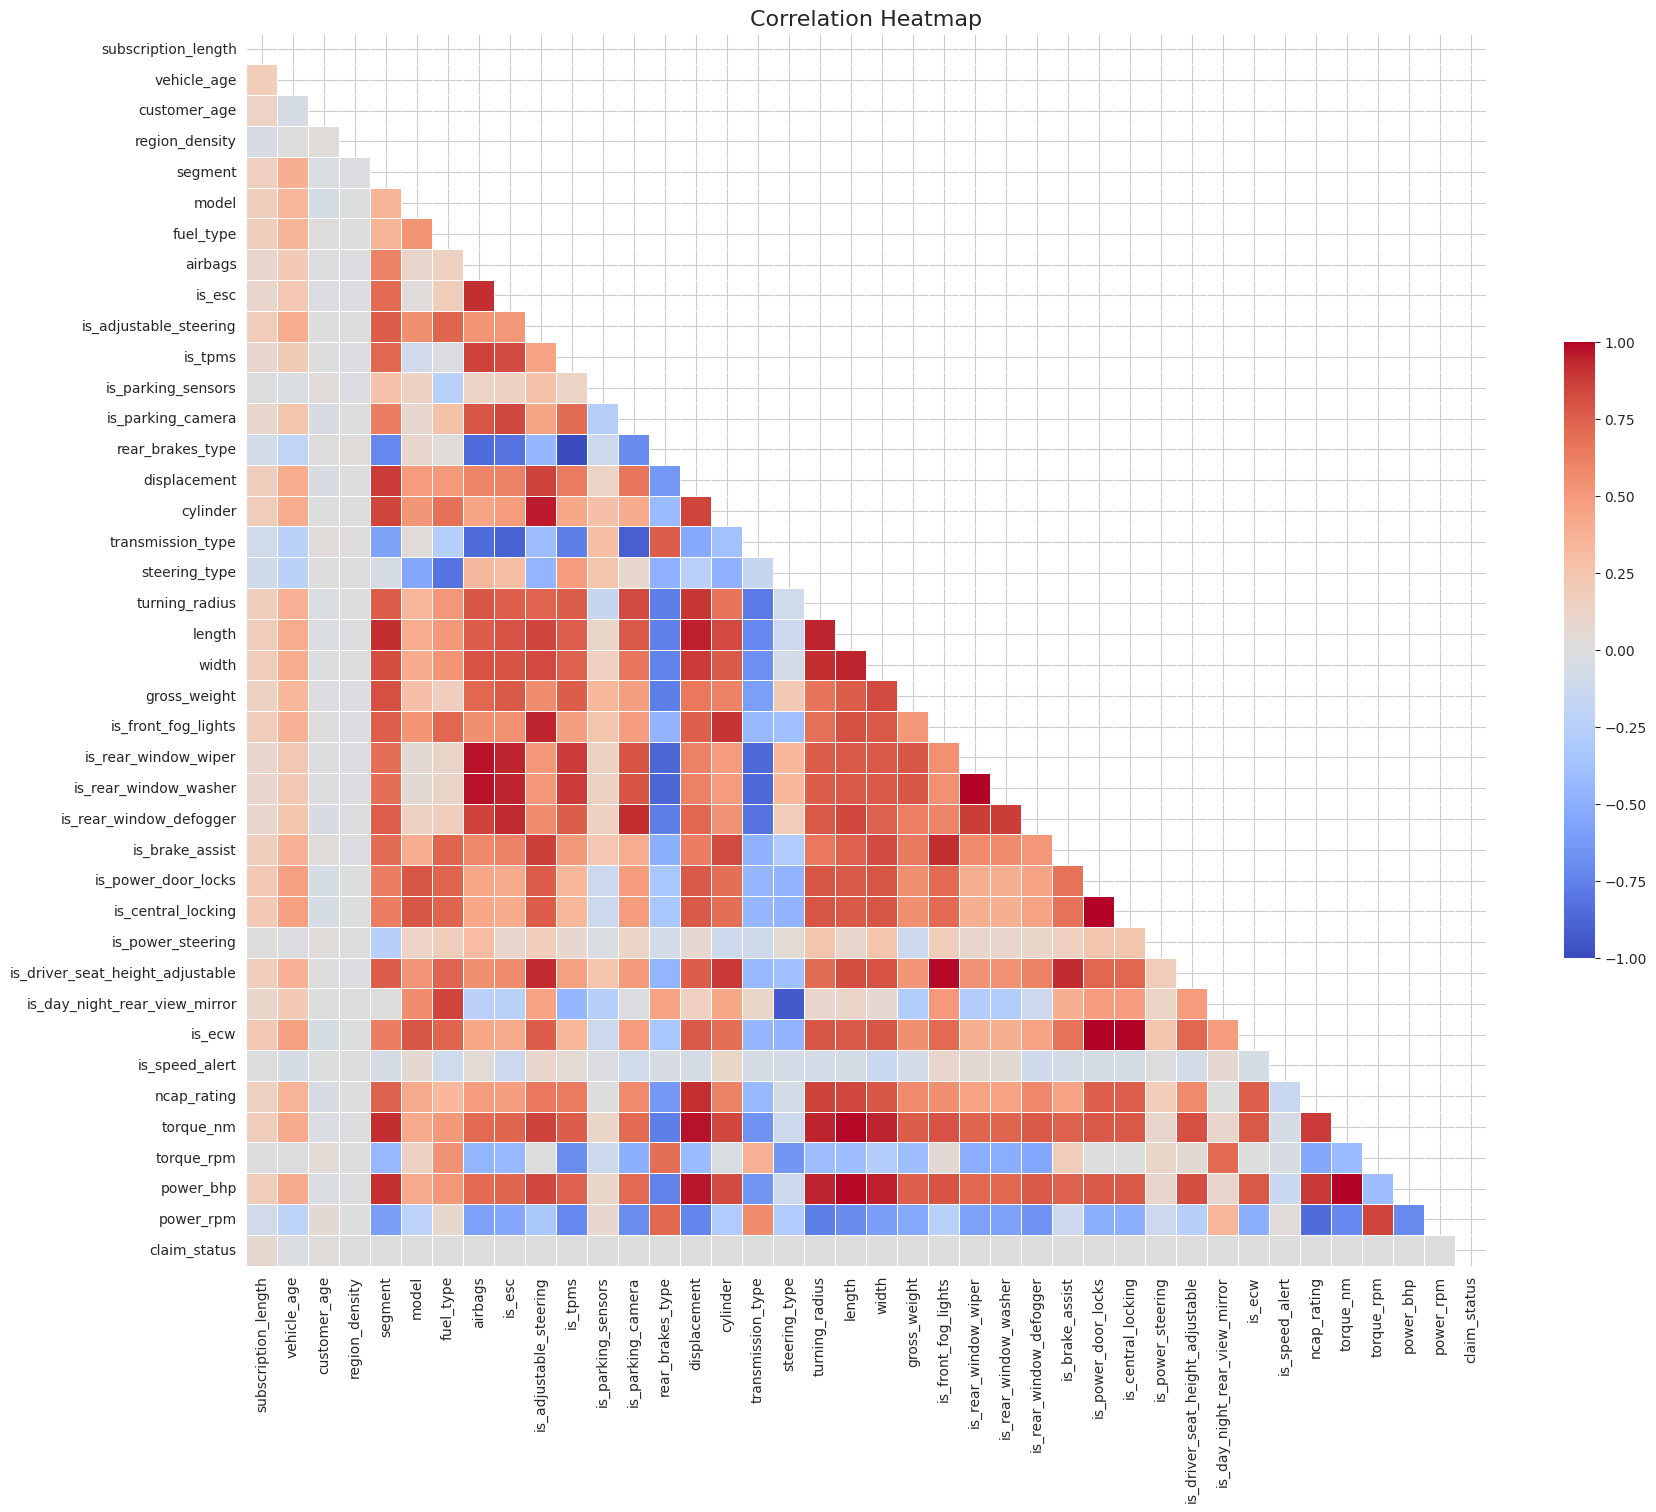

--- Top 10 Correlations with Target (claim_status) ---


subscription_length                 0.075194
vehicle_age                        -0.030852
customer_age                        0.017828
region_density                     -0.013066
cylinder                            0.012827
is_adjustable_steering              0.012814
is_front_fog_lights                 0.010896
is_parking_sensors                  0.010836
is_brake_assist                     0.010573
is_driver_seat_height_adjustable    0.009831
Name: claim_status, dtype: float64

In [47]:
# Correlation Heatmap Function
def plot_correlation_heatmap(df):
    df_temp = df.copy()

    for col in df_temp.select_dtypes(include=["object", "category"]).columns:
        df_temp[col] = df_temp[col].astype("category").cat.codes

    if "kfold" in df_temp.columns:
        df_temp = df_temp.drop("kfold", axis=1)

    corr_matrix = df_temp.corr(method="spearman")

    plt.figure(figsize=(20, 16))

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap="coolwarm",
        vmax=1,
        vmin=-1,
        center=0,
        annot=False,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )

    plt.title("Correlation Heatmap", fontsize=16)
    plt.show()

    print("--- Top 10 Correlations with Target (claim_status) ---")
    target_corr = corr_matrix["claim_status"].drop(
        "claim_status"
    )  # Sacar el target mismo
    target_corr_abs = target_corr.abs().sort_values(ascending=False)
    display(target_corr[target_corr_abs.index].head(10))


plot_correlation_heatmap(train_df)

In [ ]:
def get_top_correlations(df, threshold=0.5):
    df_temp = df.copy()
    for col in df_temp.select_dtypes(include=["object", "category"]).columns:
        df_temp[col] = df_temp[col].astype("category").cat.codes

    corr_matrix = df_temp.corr(method="spearman").abs()

    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    pairs = upper_tri.stack().reset_index()
    pairs.columns = ["Variable_1", "Variable_2", "Correlation"]

    high_corr = pairs[pairs["Correlation"] > threshold].sort_values(
        by="Correlation", ascending=False
    )

    print(f"--- Correlation pairs > {threshold} ---")
    display(high_corr)

    return high_corr


top_pairs = get_top_correlations(train_df, threshold=0.90)

--- Correlation pairs > 0.9 ---


,Variable_1,Variable_2,Correlation
1180,is_central_locking,is_ecw,1.000000
967,is_rear_window_wiper,is_rear_window_washer,1.000000
1135,is_power_door_locks,is_central_locking,1.000000
1139,is_power_door_locks,is_ecw,1.000000
423,is_tpms,rear_brakes_type,1.000000
1472,torque_nm,power_bhp,0.996059
814,length,torque_nm,0.987714
932,is_front_fog_lights,is_driver_seat_height_adjustable,0.986939
816,length,power_bhp,0.984623
310,airbags,is_rear_window_wiper,0.976107


### Hallazgos de Multicolinealidad y Estrategia de Selección

Al usar un umbral de análisis a **0.90**, se ha revelado una estructura de datos altamente redundante, explicada por dos factores: **Restricciones Físicas** (dimensiones del auto) y **Paquetes Comerciales** (equipamiento por gamas).

Para evitar problemas de colinealidad en los modelos de árboles y reducir la complejidad computacional, se define la siguiente **Estrategia de Eliminación para la fase de Data Preparation**:

| Grupo | Variable a Conservar (Representante) | Variables a Eliminar (Redundantes > 0.90) | Justificación |
| :--- | :--- | :--- | :--- |
| **Cerraduras** | `is_central_locking` | `is_ecw`, `is_power_door_locks` | Sinónimos funcionales exactos (Corr: 1.0). nos quedamos con `is_central_locking` que es la más explicativa para las 3 |
| **Limpieza** | `airbags` | `is_rear_window_wiper`, `is_rear_window_washer` | `airbags` captura la misma gama pero es más relevante para siniestros corporales y posibles reclamos por su precio. |
| **Frenos/Llantas**| `rear_brakes_type` | `is_tpms` | Se correlacionan perfectamente, lo que nos da el indicio que para un tipo de freno solo viene con esta caracteristica, por lo que hay redundancia, nos quedaremos con  `rear_brakes_type` que nos da mayor informacion. |
| **Motor** | `power_bhp` | `torque_nm`, `displacement`, `cylinder` | `power_bhp` resume el rendimiento final. Las otras son características mecánicas redundantes (tambien se elimina las rpm asociadas al torque). |
| **Dimensiones** | `length` | `width`, `turning_radius` | Un vehículo más largo correlaciona físicamente con ser más ancho y tener mayor radio de giro. |
| **Confort** | `is_front_fog_lights` | `is_driver_seat_height_adjustable` | Las luces antiniebla mostraron mayor impacto directo en la frecuencia de reclamos por daños físicos. |

**Impacto Esperado:**
Esta limpieza reducirá el dataset sin pérdida significativa de información (Varianza Explicada), permitiendo que el modelo se enfoque en las señales reales y no en el ruido repetitivo.